# Chapter 10. Big Entropy and the Generalized Linear Model

In [3]:
import os

import arviz as az
import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax import random, tree_map, vmap

import numpyro.distributions as dist

if "SVG" in os.environ:
    %config InlineBackend.figure_formats = ["svg"]
az.style.use("arviz-darkgrid")

from src import utils

%load_ext autoreload
%autoreload 2


### Code 10.1

In [4]:
p = {}
p["A"] = jnp.array([0, 0, 10, 0, 0])
p["B"] = jnp.array([0, 1, 8, 1, 0])
p["C"] = jnp.array([0, 2, 6, 2, 0])
p["D"] = jnp.array([1, 2, 4, 2, 1])
p["E"] = jnp.array([2, 2, 2, 2, 2])

### Code 10.2

In [5]:
p_norm = tree_map(lambda q: q / jnp.sum(q), p)

In [6]:
p_norm

{'A': Array([0., 0., 1., 0., 0.], dtype=float32),
 'B': Array([0. , 0.1, 0.8, 0.1, 0. ], dtype=float32),
 'C': Array([0. , 0.2, 0.6, 0.2, 0. ], dtype=float32),
 'D': Array([0.1, 0.2, 0.4, 0.2, 0.1], dtype=float32),
 'E': Array([0.2, 0.2, 0.2, 0.2, 0.2], dtype=float32)}

### Code 10.3

In [7]:
H = tree_map(lambda q: -jnp.sum(jnp.where(q == 0, 0, q * jnp.log(q))), p_norm)
H

{'A': Array(-0., dtype=float32),
 'B': Array(0.6390318, dtype=float32),
 'C': Array(0.95027053, dtype=float32),
 'D': Array(1.4708085, dtype=float32),
 'E': Array(1.609438, dtype=float32)}

### Code 10.4

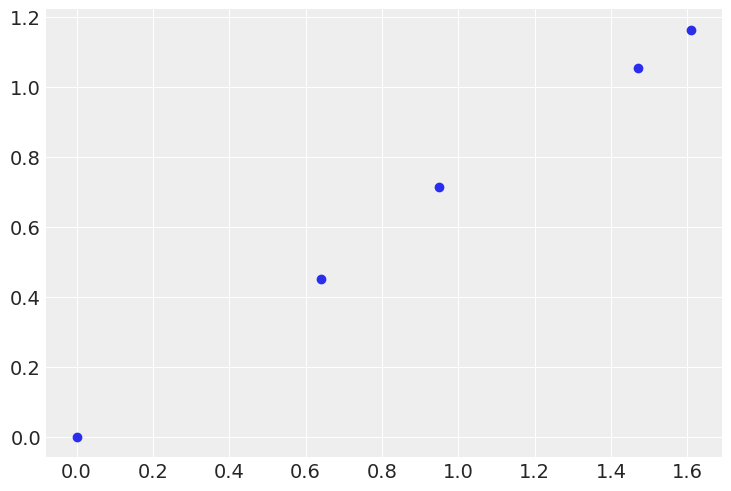

In [11]:
ways = jnp.array([1, 90, 1260, 37800, 113400])
logwayspp = jnp.log(ways) / 10

plt.scatter(H.values(), logwayspp)

### Code 10.5

In [12]:
# build list of the candidate distributions
p = {}
p[1] = jnp.array([1 / 4, 1 / 4, 1 / 4, 1 / 4])
p[2] = jnp.array([2 / 6, 1 / 6, 1 / 6, 2 / 6])
p[3] = jnp.array([1 / 6, 2 / 6, 2 / 6, 1 / 6])
p[4] = jnp.array([1 / 8, 4 / 8, 2 / 8, 1 / 8])

# compute expected value of each
tree_map(lambda p: jnp.sum(p * jnp.array([0, 1, 1, 2])), p)

{1: Array(1., dtype=float32),
 2: Array(1., dtype=float32),
 3: Array(1., dtype=float32),
 4: Array(1., dtype=float32)}

### Code 10.6

In [13]:
# compute entropy of each distribution
tree_map(lambda p: -jnp.sum(p * jnp.log(p)), p)

{1: Array(1.3862944, dtype=float32),
 2: Array(1.3296614, dtype=float32),
 3: Array(1.3296614, dtype=float32),
 4: Array(1.2130076, dtype=float32)}

### Code 10.7

In [14]:
p = 0.7
A = jnp.array([(1 - p) ** 2, p * (1 - p), (1 - p) * p, p ** 2])
A

Array([0.09, 0.21, 0.21, 0.49], dtype=float32)

### Code 10.8

In [15]:
-jnp.sum(A * jnp.log(A))

Array(1.2217286, dtype=float32)

### Code 10.9

In [16]:
def sim_p(i, G=1.4):
    x123 = dist.Uniform().sample(random.PRNGKey(i), (3,))
    x4 = (G * jnp.sum(x123, keepdims=True) - x123[1] - x123[2]) / (2 - G)
    z = jnp.sum(jnp.concatenate([x123, x4]))
    p = jnp.concatenate([x123, x4]) / z
    return {"H": -jnp.sum(p * jnp.log(p)), "p": p}

### Code 10.10

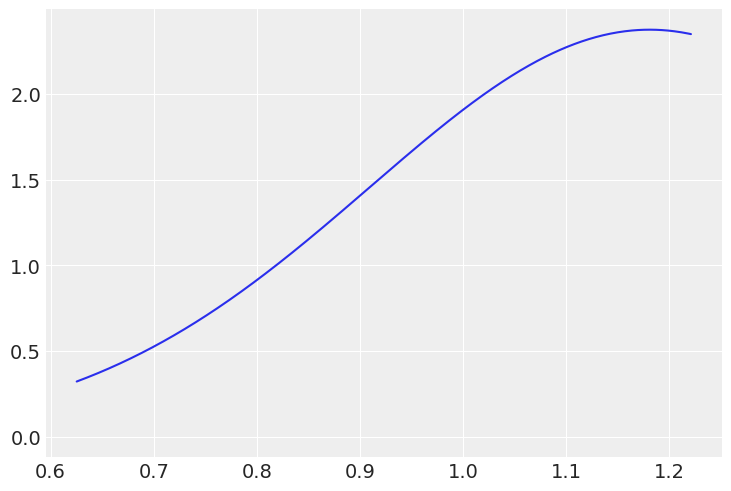

In [17]:
H = vmap(lambda i: sim_p(i, G=1.4))(jnp.arange(int(1e5)))
az.plot_kde(H["H"], bw=0.25)
plt.show()

### Code 10.11

In [18]:
entropies = H["H"]
distributions = H["p"]

### Code 10.12

In [19]:
jnp.max(entropies)

Array(1.2217282, dtype=float32)

### Code 10.13

In [20]:
distributions[jnp.argmax(entropies)]

Array([0.09018064, 0.20994426, 0.20969449, 0.49018067], dtype=float32)